## 1 Functions and module

### 1.1 Modules

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import seaborn as sns
import scipy.stats as stats
%matplotlib inline 
import scipy
import itertools
import importlib
from scipy.stats import ranksums
from scipy.stats import rankdata

In [2]:
pd.set_option('display.max_columns', None)
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

### 1.2 Functions

In [3]:
def fdr(p_vals):
    """
    Perform FDR correction on a list of p-values.

    Parameters:
    - p_vals (array-like): List or array of p-values.

    Returns:
    - np.ndarray: Array of FDR-adjusted p-values.
    """
    p = np.asfarray(p_vals)
    valid_mask = ~np.isnan(p)
    valid_p = p[valid_mask]

    by_descend = valid_p.argsort()[::-1]
    by_orig = by_descend.argsort()
    valid_p = valid_p[by_descend]

    ranked_p_values = rankdata(valid_p, method='max')
    fdr = valid_p * len(valid_p) / ranked_p_values
    fdr = np.minimum(1, np.minimum.accumulate(fdr))

    result = np.full_like(p, np.nan)
    result[valid_mask] = fdr[by_orig]
    
    return result


In [4]:
def customize_plot(ax, 
                   xaxis_title_size=12, 
                   xaxis_tick_label_size=10, 
                   yaxis_title_size=12, 
                   yaxis_tick_label_size=10, 
                   panel_title='A', 
                   panel_title_size=14,
                   xaxis_title=None, 
                   yaxis_title=None):
    """
    Customize the plot by controlling the font size and text for x-axis, y-axis titles, tick labels, and panel title.
    
    Parameters:
    ax (matplotlib.axes.Axes): The axis to customize.
    xaxis_title_size (int): Font size for the x-axis title.
    xaxis_tick_label_size (int): Font size for the x-axis tick labels.
    yaxis_title_size (int): Font size for the y-axis title.
    yaxis_tick_label_size (int): Font size for the y-axis tick labels.
    panel_title (str): Text for the panel title.
    panel_title_size (int): Font size for the panel title.
    xaxis_title (str or None): Text for the x-axis title. If None, keep the existing title.
    yaxis_title (str or None): Text for the y-axis title. If None, keep the existing title.
    """
    
    # Set the x-axis title and font size
    if xaxis_title is not None:
        ax.set_xlabel(xaxis_title, fontsize=xaxis_title_size)
    else:
        ax.set_xlabel(ax.get_xlabel(), fontsize=xaxis_title_size)
    
    # Set the y-axis title and font size
    if yaxis_title is not None:
        ax.set_ylabel(yaxis_title, fontsize=yaxis_title_size)
    else:
        ax.set_ylabel(ax.get_ylabel(), fontsize=yaxis_title_size)
    
    # Set the x-axis tick label font size
    ax.tick_params(axis='x', labelsize=xaxis_tick_label_size)
    
    # Set the y-axis tick label font size
    ax.tick_params(axis='y', labelsize=yaxis_tick_label_size)
    
    # Set the panel title with custom text and font size
    if panel_title is not None:
        ax.set_title(panel_title, loc='center', fontsize=panel_title_size)

## 2 Input and output address

In [5]:
data_dir = 'data/'
gene_combination_unordered_address = data_dir+'TripleKnockoutTable_for_gene_level_tumor_metrics_ignore_position.csv'
two_way_epistasis_output = data_dir+'TripleKnockoutTable_for_two_way_epistasis.csv'
three_way_epistasis_output = data_dir+'TripleKnockoutTable_for_three_way_epistasis.csv'

## 3 Data Input and simple QC

In [6]:
gene_df = pd.read_csv(gene_combination_unordered_address)
aggregated_two_way_results = pd.read_csv(two_way_epistasis_output)
aggregated_three_way_results = pd.read_csv(three_way_epistasis_output)

## 4 Fitness comparison across KO

### 4.1 Cas12a

<font size="10" color="red"> Fig. 7(d)</font>

In [7]:
query_df = gene_df[gene_df.Mouse_genotype=='KTCas12a']
query_df = query_df[query_df.Array_category!='Triple_Inert']

In [8]:
temp_o = ['Single_TSG', 'Double_TSG','Triple_TSG'  ]
x_axis_p = 'Array_category'
query_df[x_axis_p] = pd.Categorical(query_df[x_axis_p], ordered=True, categories=temp_o)
query_df = query_df.sort_values(by=x_axis_p)

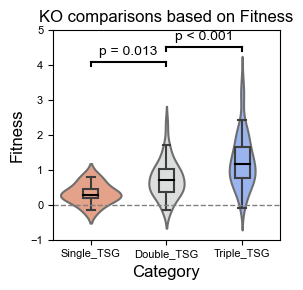

In [11]:
# Plot the violin plot with embedded boxplot
fig2, ax1 = plt.subplots(1, 1, figsize=(3, 3))

trait_of_interest = 'Fitness'
bt_trait = f'{trait_of_interest}_bootstrap_median'
x_axis_p = 'Array_category'


# rank sum test
comparisons = [('Single_TSG', 'Double_TSG'), ('Double_TSG', 'Triple_TSG')]
y_absolute_list = [0.85, 0.92]
# Violin plot for log2-transformed data
sns.violinplot(
    data=query_df,
    x=x_axis_p,
    y=bt_trait,
    palette='coolwarm_r',
    inner=None,
    linewidth=1.5,
    ax=ax1
)

# Boxplot overlay for log2-transformed data
sns.boxplot(
    data=query_df,
    x=x_axis_p,
    y=bt_trait,
    width=0.2,
    showcaps=True,
    boxprops={'facecolor': 'none', "zorder": 2},
    showfliers=False,
    whiskerprops={'linewidth': 1.5},
    medianprops={'color': 'black', 'linewidth': 1.5},
    ax=ax1
)

# Customize plot
ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
ax1.set_ylabel('Fitness')
ax1.set_xlabel('Category')

ax1.set_ylim(-1, 5)  
# Perform rank sum tests and annotate p-values
for i, (control, comparison) in enumerate(comparisons):
    # Filter data for the two groups
    data_control = query_df[query_df[x_axis_p] == control][bt_trait]
    data_comparison = query_df[query_df[x_axis_p] == comparison][bt_trait]
    # Perform the rank sum test
    _, p_value = ranksums(data_control, data_comparison)

    # Absolute positioning in axes coordinates
    y_absolute, h_absolute = y_absolute_list[i], 0.02  # Position for the horizontal line in axes fraction
    x1, x2 = i, i + 1  # Position for horizontal lines on x-axis (data coordinates)

    # Draw a horizontal line in absolute axes coordinates
    ax1.plot([x1, x2], [y_absolute, y_absolute], lw=1.5, color='k', transform=ax1.get_xaxis_transform())

    # Draw small vertical lines ("ticks") in absolute axes coordinates
    tick_height = 0.02  # Height of the vertical tick lines
    ax1.plot([x1, x1], [y_absolute - tick_height, y_absolute], lw=1.5, color='k', transform=ax1.get_xaxis_transform())
    ax1.plot([x2, x2], [y_absolute - tick_height, y_absolute], lw=1.5, color='k', transform=ax1.get_xaxis_transform())

    # Conditional annotation for p-value
    if p_value < 0.001:
        p_text = "p < 0.001"
    else:
        p_text = f"p = {p_value:.3f}"

    # Annotate the p-value above the horizontal line
    ax1.text((x1 + x2) * 0.5, y_absolute + h_absolute, p_text, ha='center', va='bottom', color='k', transform=ax1.get_xaxis_transform())

customize_plot(ax1, xaxis_title_size=12, 
               xaxis_tick_label_size=8, 
                   yaxis_title_size=12, 
                   yaxis_tick_label_size=8, 
                   panel_title='KO comparisons based on Fitness', 
                   panel_title_size=12,
                   xaxis_title=None)
plt.tight_layout()
plt.show()


### 4.2 KT

<font size="10" color="red"> Fig. S9(c)</font>

In [12]:
query_df = gene_df[gene_df.Mouse_genotype=='KT']
query_df = query_df[query_df.Array_category!='Triple_Inert']

In [13]:
temp_o = ['Single_TSG', 'Double_TSG','Triple_TSG'  ]
x_axis_p = 'Array_category'
query_df[x_axis_p] = pd.Categorical(query_df[x_axis_p], ordered=True, categories=temp_o)
query_df = query_df.sort_values(by=x_axis_p)

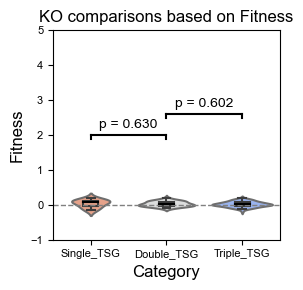

In [14]:
# Plot the violin plot with embedded boxplot
fig, ax1 = plt.subplots(1, 1, figsize=(3, 3))

trait_of_interest = 'Fitness'
bt_trait = f'{trait_of_interest}_bootstrap_median'
x_axis_p = 'Array_category'


# rank sum test
comparisons = [('Single_TSG', 'Double_TSG'), ('Double_TSG', 'Triple_TSG')]
y_absolute_list = [0.5, 0.6]
# Violin plot for log2-transformed data
sns.violinplot(
    data=query_df,
    x=x_axis_p,
    y=bt_trait,
    palette='coolwarm_r',
    inner=None,
    linewidth=1.5,
    ax=ax1
)

# Boxplot overlay for log2-transformed data
sns.boxplot(
    data=query_df,
    x=x_axis_p,
    y=bt_trait,
    width=0.2,
    showcaps=True,
    boxprops={'facecolor': 'none', "zorder": 2},
    showfliers=False,
    whiskerprops={'linewidth': 1.5},
    medianprops={'color': 'black', 'linewidth': 1.5},
    ax=ax1
)

# Customize plot
ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
ax1.set_ylabel('Fitness')
ax1.set_xlabel('Category')

ax1.set_ylim(-1, 5)  
# Perform rank sum tests and annotate p-values
for i, (control, comparison) in enumerate(comparisons):
    # Filter data for the two groups
    data_control = query_df[query_df[x_axis_p] == control][bt_trait]
    data_comparison = query_df[query_df[x_axis_p] == comparison][bt_trait]
    # Perform the rank sum test
    _, p_value = ranksums(data_control, data_comparison)

    # Absolute positioning in axes coordinates
    y_absolute, h_absolute = y_absolute_list[i], 0.02  # Position for the horizontal line in axes fraction
    x1, x2 = i, i + 1  # Position for horizontal lines on x-axis (data coordinates)

    # Draw a horizontal line in absolute axes coordinates
    ax1.plot([x1, x2], [y_absolute, y_absolute], lw=1.5, color='k', transform=ax1.get_xaxis_transform())

    # Draw small vertical lines ("ticks") in absolute axes coordinates
    tick_height = 0.02  # Height of the vertical tick lines
    ax1.plot([x1, x1], [y_absolute - tick_height, y_absolute], lw=1.5, color='k', transform=ax1.get_xaxis_transform())
    ax1.plot([x2, x2], [y_absolute - tick_height, y_absolute], lw=1.5, color='k', transform=ax1.get_xaxis_transform())

    # Conditional annotation for p-value
    if p_value < 0.001:
        p_text = "p < 0.001"
    else:
        p_text = f"p = {p_value:.3f}"

    # Annotate the p-value above the horizontal line
    ax1.text((x1 + x2) * 0.5, y_absolute + h_absolute, p_text, ha='center', va='bottom', color='k', transform=ax1.get_xaxis_transform())

customize_plot(ax1, xaxis_title_size=12, 
               xaxis_tick_label_size=8, 
                   yaxis_title_size=12, 
                   yaxis_tick_label_size=8, 
                   panel_title='KO comparisons based on Fitness', 
                   panel_title_size=12,
                   xaxis_title=None)
plt.tight_layout()
plt.show()


## 5 Observed vs Expected 2-KO plot

### 5.1 KTCas12a

<font size="10" color="red"> Fig. 7(g)</font>

In [15]:
query_df = aggregated_two_way_results[aggregated_two_way_results.Mouse_genotype=='KTCas12a'].copy()

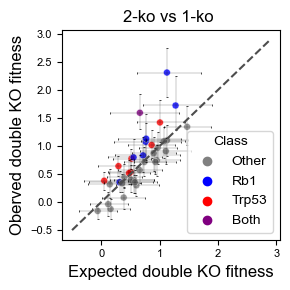

In [16]:
gs = gridspec.GridSpec(5, 5) 
fig3 = plt.figure(figsize=(3, 3))

# KTC plot
ax1 = fig3.add_subplot(gs[:5, 0:5])

# Data setup
temp_df = query_df

temp_df['Class'] = 'Other'
temp_df.loc[temp_df.gene_combination_unordered.str.contains('Rb1'),'Class'] = 'Rb1'
temp_df.loc[temp_df.gene_combination_unordered.str.contains('Trp53'),'Class'] = 'Trp53'
temp_df.loc[(temp_df.gene_combination_unordered.str.contains('Trp53'))&(temp_df.gene_combination_unordered.str.contains('Rb1')),'Class'] = 'Both'

color_dic = {'Other':'grey',
            'Rb1':'blue',
            'Trp53':'red',
            'Both':'purple'}
dot_size = 25

trait1 = 'expected_double_ko'
trait1_estimate = f'{trait1}_bootstrap_median'
trait1_pvalue = f'{trait1}_pvalue_twoside'
trait1_up = f'{trait1}_97.5P'
trait1_low = f'{trait1}_2.5P'

trait2 = 'observed_double_ko'
trait2_estimate = f'{trait2}_bootstrap_median'
trait2_pvalue = f'{trait2}_pvalue_twoside'
trait2_up = f'{trait2}_97.5P'
trait2_low = f'{trait2}_2.5P'

# Labels
temp_x_label_name = 'Expected double KO fitness'
temp_y_label_name = 'Oberved double KO fitness'


# Threshold to split data subset contains rb1 or Trp53
temp_df_sub1 = temp_df[temp_df.gene_combination_unordered.str.contains('Rb1|Trp53')]
# Plot groups separately with high-contrast color palette
sns.scatterplot(data=temp_df, x=trait1_estimate, y=trait2_estimate, ax=ax1, s=dot_size, hue='Class',palette = color_dic, alpha=0.8)

# sns.scatterplot(data=temp_df_sub1, x=trait1_estimate, y=trait2_estimate, ax=ax1, s=dot_size, color='red')

temp_x_err = [temp_df[trait1_estimate]-temp_df[trait1_low], temp_df[trait1_up]-temp_df[trait1_estimate]]
temp_y_err = [temp_df[trait2_estimate]-temp_df[trait2_low], temp_df[trait2_up]-temp_df[trait2_estimate]]

ax1.errorbar(data=temp_df, x=trait1_estimate, y=trait2_estimate,
             xerr=temp_x_err, yerr=temp_y_err, 
             linestyle='', color='black', elinewidth=0.15, capsize=0.5, capthick=0.5)
             

# Diagonal reference line
temp1 = min(ax1.get_xlim()[0], ax1.get_ylim()[0])
temp2 = max(ax1.get_xlim()[1], ax1.get_ylim()[1])
ax1.plot((temp1, temp2), (temp1, temp2), ls="--", color=".3")

# Set axis labels
ax1.set_xlabel(temp_x_label_name)
ax1.set_ylabel(temp_y_label_name)

customize_plot(ax1, xaxis_title_size=12, 
               xaxis_tick_label_size=8, 
                   yaxis_title_size=12, 
                   yaxis_tick_label_size=8, 
                   panel_title='2-ko vs 1-ko ', 
                   panel_title_size=12,
                   xaxis_title=None)
plt.tight_layout()
plt.show()


### 5.2 KT

In [17]:
query_df = aggregated_two_way_results[aggregated_two_way_results.Mouse_genotype=='KT'].copy()

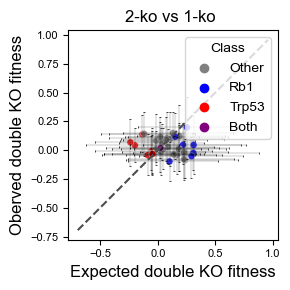

In [18]:
# Prepare the gridspec layout and figure
gs = gridspec.GridSpec(5, 5) 
fig3 = plt.figure(figsize=(3, 3))

# KTC plot
ax1 = fig3.add_subplot(gs[:5, 0:5])

# Data setup
temp_df = query_df

temp_df['Class'] = 'Other'
temp_df.loc[temp_df.gene_combination_unordered.str.contains('Rb1'),'Class'] = 'Rb1'
temp_df.loc[temp_df.gene_combination_unordered.str.contains('Trp53'),'Class'] = 'Trp53'
temp_df.loc[(temp_df.gene_combination_unordered.str.contains('Trp53'))&(temp_df.gene_combination_unordered.str.contains('Rb1')),'Class'] = 'Both'

color_dic = {'Other':'grey',
            'Rb1':'blue',
            'Trp53':'red',
            'Both':'purple'}
dot_size = 25

trait1 = 'expected_double_ko'
trait1_estimate = f'{trait1}_bootstrap_median'
trait1_pvalue = f'{trait1}_pvalue_twoside'
trait1_up = f'{trait1}_97.5P'
trait1_low = f'{trait1}_2.5P'

trait2 = 'observed_double_ko'
trait2_estimate = f'{trait2}_bootstrap_median'
trait2_pvalue = f'{trait2}_pvalue_twoside'
trait2_up = f'{trait2}_97.5P'
trait2_low = f'{trait2}_2.5P'

# Labels
temp_x_label_name = 'Expected double KO fitness'
temp_y_label_name = 'Oberved double KO fitness'


# Threshold to split data subset contains rb1 or Trp53
temp_df_sub1 = temp_df[temp_df.gene_combination_unordered.str.contains('Rb1|Trp53')]
# Plot groups separately with high-contrast color palette
sns.scatterplot(data=temp_df, x=trait1_estimate, y=trait2_estimate, ax=ax1, s=dot_size, hue='Class',palette = color_dic, alpha=0.8)

# sns.scatterplot(data=temp_df_sub1, x=trait1_estimate, y=trait2_estimate, ax=ax1, s=dot_size, color='red')

temp_x_err = [temp_df[trait1_estimate]-temp_df[trait1_low], temp_df[trait1_up]-temp_df[trait1_estimate]]
temp_y_err = [temp_df[trait2_estimate]-temp_df[trait2_low], temp_df[trait2_up]-temp_df[trait2_estimate]]

ax1.errorbar(data=temp_df, x=trait1_estimate, y=trait2_estimate,
             xerr=temp_x_err, yerr=temp_y_err, 
             linestyle='', color='black', elinewidth=0.15, capsize=0.5, capthick=0.5)
             

# Diagonal reference line
temp1 = min(ax1.get_xlim()[0], ax1.get_ylim()[0])
temp2 = max(ax1.get_xlim()[1], ax1.get_ylim()[1])
ax1.plot((temp1, temp2), (temp1, temp2), ls="--", color=".3")

# Set axis labels
ax1.set_xlabel(temp_x_label_name)
ax1.set_ylabel(temp_y_label_name)

customize_plot(ax1, xaxis_title_size=12, 
               xaxis_tick_label_size=8, 
                   yaxis_title_size=12, 
                   yaxis_tick_label_size=8, 
                   panel_title='2-ko vs 1-ko ', 
                   panel_title_size=12,
                   xaxis_title=None)
plt.tight_layout()
plt.show()


## 6 KO effect at different genetic background

<font size="10" color="red"> Fig. 7(e)</font>

In [19]:
query_df = aggregated_two_way_results[aggregated_two_way_results.Mouse_genotype=='KTCas12a'].copy()

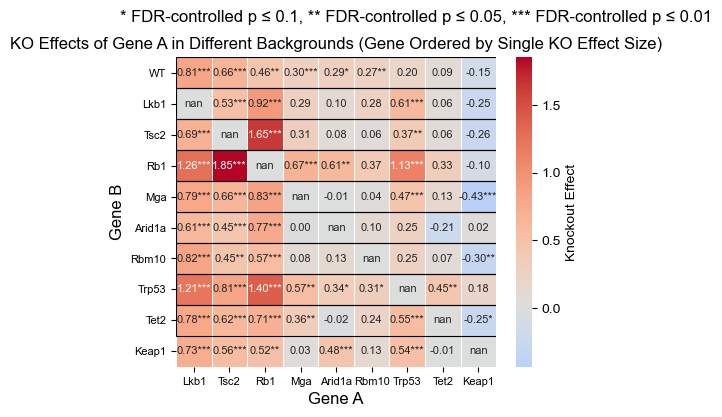

In [23]:
# Combine KO effects and p-values for sorting genes and highlighting
gene_effects = pd.concat([
    query_df[['gene_a', 'ko_a_in_wt_bootstrap_median', 'ko_a_in_wt_pvalue_twoside']].rename(columns={
        'gene_a': 'gene',
        'ko_a_in_wt_bootstrap_median': 'ko_effect',
        'ko_a_in_wt_pvalue_twoside': 'p_value'
    }),
    query_df[['gene_b', 'ko_b_in_wt_bootstrap_median', 'ko_b_in_wt_pvalue_twoside']].rename(columns={
        'gene_b': 'gene',
        'ko_b_in_wt_bootstrap_median': 'ko_effect',
        'ko_b_in_wt_pvalue_twoside': 'p_value'
    })
])
gene_effects = gene_effects.drop_duplicates()

# Calculate mean KO effect for each gene and sort
sorted_genes = (
    gene_effects.groupby('gene')['ko_effect']
    .mean()
    .sort_values(ascending=False)
    .index.tolist()
)

# Initialize matrices for the heatmap, annotations, and p-values
heatmap_matrix = pd.DataFrame(index=sorted_genes, columns=sorted_genes, data=np.nan)
annotations = pd.DataFrame(index=sorted_genes, columns=sorted_genes, data="")
pvalue_matrix = pd.DataFrame(index=sorted_genes, columns=sorted_genes, data=np.nan)

# Helper function to format annotation with stars for FDR-controlled p-values
def format_annotation(value, p_value):
    if p_value < 0.01:
        return f"{value:.2f}***"
    elif p_value < 0.05:
        return f"{value:.2f}**"
    elif p_value < 0.1:
        return f"{value:.2f}*"
    else:
        return f"{value:.2f}"

# Fill the matrices
for _, row in query_df.iterrows():
    gene_a = row['gene_a']
    gene_b = row['gene_b']
    value_a_in_b = row['ko_a_in_b_ko_bootstrap_median']
    value_b_in_a = row['ko_b_in_a_ko_bootstrap_median']
    p_value_a_in_b = row['ko_a_in_b_ko_pvalue_twoside']
    p_value_b_in_a = row['ko_b_in_a_ko_pvalue_twoside']

    heatmap_matrix.loc[gene_b, gene_a] = value_a_in_b
    heatmap_matrix.loc[gene_a, gene_b] = value_b_in_a
    pvalue_matrix.loc[gene_b, gene_a] = p_value_a_in_b
    pvalue_matrix.loc[gene_a, gene_b] = p_value_b_in_a

# Add the WT row and column
for gene in sorted_genes:
    ko_effect = gene_effects.loc[gene_effects['gene'] == gene, 'ko_effect'].values[0]
    p_value = gene_effects.loc[gene_effects['gene'] == gene, 'p_value'].values[0]
    heatmap_matrix.loc[gene, 'WT'] = ko_effect
    heatmap_matrix.loc['WT', gene] = ko_effect
    pvalue_matrix.loc[gene, 'WT'] = p_value
    pvalue_matrix.loc['WT', gene] = p_value
    annotations.loc[gene, 'WT'] = format_annotation(ko_effect, p_value)
    annotations.loc['WT', gene] = format_annotation(ko_effect, p_value)

heatmap_matrix.loc['WT', 'WT'] = 0
pvalue_matrix.loc['WT', 'WT'] = np.nan
annotations.loc['WT', 'WT'] = ""

# Add WT to the sorted list
sorted_genes_with_wt = ['WT'] + sorted_genes
heatmap_matrix = heatmap_matrix.loc[sorted_genes_with_wt, sorted_genes_with_wt]
pvalue_matrix = pvalue_matrix.loc[sorted_genes_with_wt, sorted_genes_with_wt]
annotations = annotations.loc[sorted_genes_with_wt, sorted_genes_with_wt]

# Set p-values in the first column (WT column) to NaN for FDR calculation
pvalue_matrix['WT'] = np.nan

# Flatten p-value matrix to exclude diagonal
p_vals_flat = pvalue_matrix.values.flatten()
mask = ~np.eye(pvalue_matrix.shape[0], dtype=bool).flatten()
fdr_corrected = np.full_like(p_vals_flat, np.nan)
fdr_corrected[mask] = fdr(p_vals_flat[mask])

# Reshape FDR-corrected values back into matrix form
fdr_matrix = pd.DataFrame(
    fdr_corrected.reshape(pvalue_matrix.shape),
    index=pvalue_matrix.index,
    columns=pvalue_matrix.columns
)

heatmap_matrix.replace(np.nan, 0, inplace=True)
# Update annotations with FDR-controlled p-values
for gene_a in sorted_genes_with_wt:
    for gene_b in sorted_genes_with_wt:
        if not np.isnan(fdr_matrix.loc[gene_b, gene_a]):
            value = heatmap_matrix.loc[gene_b, gene_a]
            p_value = fdr_matrix.loc[gene_b, gene_a]
            annotations.loc[gene_b, gene_a] = format_annotation(value, p_value)
# Annotate cells with a value of 0 as "NaN"
for gene_a in heatmap_matrix.index:
    for gene_b in heatmap_matrix.columns:
        if heatmap_matrix.loc[gene_a, gene_b] == 0:
            annotations.loc[gene_a, gene_b] = "nan" 
            
            
heatmap_matrix = heatmap_matrix.iloc[:,1:]




annotations = annotations.iloc[:,1:]
# Plot the heatmap
fig15, ax1 = plt.subplots(1, 1, figsize=(5, 4))
ax=sns.heatmap(
    heatmap_matrix, annot=annotations, fmt="", cmap="coolwarm",
    cbar_kws={'label': 'Knockout Effect'}, annot_kws={'size': 8}, center=0, linewidths=0.5
)

fig15.text(
    0.05, 1.,
    "* FDR-controlled p ≤ 0.1, ** FDR-controlled p ≤ 0.05, *** FDR-controlled p ≤ 0.01",
    fontsize=12, ha='left', color='black'
)

for i in range(len(sorted_genes)):
    rect = plt.Rectangle((0, i), len(sorted_genes)+1, 1, fill=False, edgecolor='black', lw=0.8)
    ax.add_patch(rect)

    
customize_plot(ax1, xaxis_title_size=12, 
               xaxis_tick_label_size=8, 
                   yaxis_title_size=12, 
                   yaxis_tick_label_size=8, 
                   panel_title='', 
                   panel_title_size=12,
                   xaxis_title=None)
plt.title("KO Effects of Gene A in Different Backgrounds (Gene Ordered by Single KO Effect Size)")
plt.xlabel("Gene A")
plt.ylabel("Gene B")
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()

## 7 Two way Epistais Plot 

### 7.1 Epistasis heat map 

<font size="10" color="red"> Fig. 7(f)</font>

In [27]:
query_df = aggregated_two_way_results[aggregated_two_way_results.Mouse_genotype=='KTCas12a'].copy()

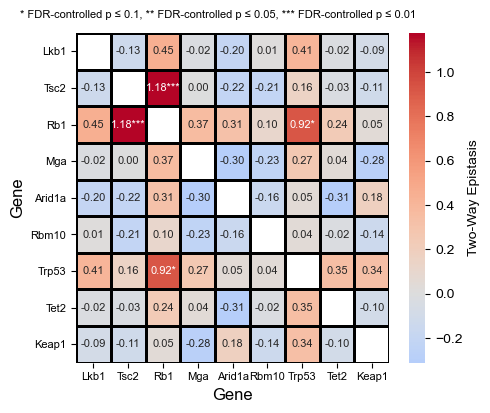

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import rankdata



# Combine KO effects and p-values for sorting genes and highlighting
gene_effects = pd.concat([
    query_df[['gene_a', 'ko_a_in_wt_bootstrap_median']].rename(columns={
        'gene_a': 'gene',
        'ko_a_in_wt_bootstrap_median': 'ko_effect'
    }),
    query_df[['gene_b', 'ko_b_in_wt_bootstrap_median']].rename(columns={
        'gene_b': 'gene',
        'ko_b_in_wt_bootstrap_median': 'ko_effect'
    })
])
gene_effects = gene_effects.drop_duplicates()

# Calculate mean KO effect for each gene and sort
sorted_genes = (
    gene_effects.groupby('gene')['ko_effect']
    .mean()
    .sort_values(ascending=False)
    .index.tolist()
)

# Create matrices for two-way epistasis
two_way_matrix = pd.DataFrame(index=sorted_genes, columns=sorted_genes, data=np.nan)
pvalue_matrix = pd.DataFrame(index=sorted_genes, columns=sorted_genes, data=np.nan)
annotations = pd.DataFrame(index=sorted_genes, columns=sorted_genes, data="")  # For star annotations

trait = 'epistasis'
trait_estimate = f'{trait}_bootstrap_median'
trait_pvalue = f'{trait}_pvalue_twoside'

# Fill the two-way epistasis matrix and p-value matrix
for _, row in query_df.iterrows():
    gene_combination = row['gene_combination_unordered']
    mean_epistasis = row[trait_estimate]
    p_value = row[trait_pvalue]
    genes_in_combination = [gene for gene in gene_combination.split('_') if gene != 'Safe']
    
    if len(genes_in_combination) == 2:
        gene_a, gene_b = genes_in_combination
        two_way_matrix.loc[gene_a, gene_b] = mean_epistasis
        two_way_matrix.loc[gene_b, gene_a] = mean_epistasis  # Symmetry
        pvalue_matrix.loc[gene_a, gene_b] = p_value
        pvalue_matrix.loc[gene_b, gene_a] = p_value  # Symmetry

# Flatten the lower triangle of the p-value matrix to exclude duplicates
lower_triangle_mask = np.tril(np.ones_like(pvalue_matrix, dtype=bool), k=-1)
p_vals_flat = pvalue_matrix.values[lower_triangle_mask]

# Apply FDR correction to the lower triangle
fdr_corrected = np.full_like(pvalue_matrix.values, np.nan)
fdr_corrected[lower_triangle_mask] = fdr(p_vals_flat)

# Reflect the corrected FDR values back to the upper triangle
fdr_matrix = pd.DataFrame(
    fdr_corrected,
    index=pvalue_matrix.index,
    columns=pvalue_matrix.columns
)

# Reflect lower triangle FDR values to the upper triangle without summing
for i in range(fdr_matrix.shape[0]):
    for j in range(i):  # Only loop over the lower triangle
        fdr_matrix.iloc[j, i] = fdr_matrix.iloc[i, j]  # Reflect lower to upper

# Generate the annotation matrix based on the FDR-controlled values
for gene_a in sorted_genes:
    for gene_b in sorted_genes:
        if not np.isnan(fdr_matrix.loc[gene_a, gene_b]):
            value = two_way_matrix.loc[gene_a, gene_b]
            p_value = fdr_matrix.loc[gene_a, gene_b]
            if p_value < 0.01:
                annotations.loc[gene_a, gene_b] = f"{value:.2f}***"
            elif p_value < 0.05:
                annotations.loc[gene_a, gene_b] = f"{value:.2f}**"
            elif p_value < 0.1:
                annotations.loc[gene_a, gene_b] = f"{value:.2f}*"
            else:
                annotations.loc[gene_a, gene_b] = f"{value:.2f}"

# Reorder rows and columns based on sorted genes
two_way_matrix = two_way_matrix.loc[sorted_genes, sorted_genes]
annotations = annotations.loc[sorted_genes, sorted_genes]

# Plot the heatmap

# Plot the violin plot with embedded boxplot
fig4, ax1 = plt.subplots(1, 1, figsize=(5, 4))
ax1 = sns.heatmap(
    two_way_matrix, annot=annotations, fmt="", cmap="coolwarm",
    cbar_kws={'label': 'Two-Way Epistasis'}, annot_kws={'size': 8}, center=0,linewidths=1,  # Thicker line for box edges
    linecolor='black'  # Black borders for all boxes
)

# Add criteria for stars as text on the plot
fig4.text(
    0.05, 1.,
    "* FDR-controlled p ≤ 0.1, ** FDR-controlled p ≤ 0.05, *** FDR-controlled p ≤ 0.01",
    fontsize=8, ha='left', color='black'
)

plt.title("Full Two-Way Epistasis Heatmap (Gene Ordered by Single KO Effect Size)")
plt.xlabel("Gene")
plt.ylabel("Gene")
plt.xticks(rotation=0)
customize_plot(ax1, xaxis_title_size=12, 
               xaxis_tick_label_size=8, 
                   yaxis_title_size=12, 
                   yaxis_tick_label_size=8, 
                   panel_title='', 
                   panel_title_size=12,
                   xaxis_title=None)

plt.tight_layout()
plt.show()

#### Just top half 

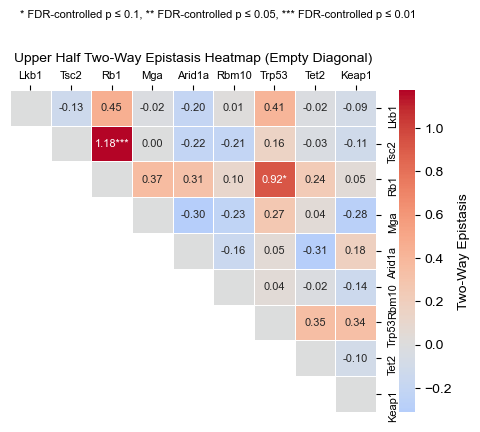

In [29]:
# Mask the lower triangle (but keep the diagonal visible)
mask = np.tril(np.ones_like(two_way_matrix, dtype=bool), k=-1)  # Only lower triangle is masked

# Set diagonal annotations to empty (""), and keep values as NaN for empty visual effect
for i in range(len(two_way_matrix)):
    two_way_matrix.iloc[i, i] = 0  # Placeholder value (e.g., 0, can use small non-rendered value)
    annotations.iloc[i, i] = ""  # Empty annotation

# Plot the heatmap
fig14, ax1 = plt.subplots(1, 1, figsize=(5, 4))
ax1 = sns.heatmap(
    two_way_matrix,
    mask=mask,  # Mask lower triangle but not diagonal
    annot=annotations, fmt="", cmap="coolwarm",
    cbar_kws={'label': 'Two-Way Epistasis'}, annot_kws={'size': 8},
    center=0, linewidths=0.5, xticklabels=True, yticklabels=True
)

# Move x-axis to the top
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('')
ax1.set_ylabel('')

# Move y-axis to the right
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')
ax1.set_ylabel("Gene", fontsize=10)

# Fix vertical alignment of right tick labels
ax1.yaxis.set_tick_params(pad=5, rotation=90)  # Adjust padding and set rotation to 0 for alignment

# Change axis tick label sizes
ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)

# Adjust the title
plt.title("Upper Half Two-Way Epistasis Heatmap (Empty Diagonal)", 
          fontsize=10, pad=20)

# Add criteria for stars as text on the plot
fig14.text(
    0.05, 1.05,
    "* FDR-controlled p ≤ 0.1, ** FDR-controlled p ≤ 0.05, *** FDR-controlled p ≤ 0.01",
    fontsize=8, ha='left', color='black'
)

# Tighten layout
plt.tight_layout()
plt.show()


## 8 Top2 positive epistasis examples 

<font size="10" color="red"> Fig. 7(h) and S9(d)</font>

In [31]:
Cas12a_df = aggregated_two_way_results[aggregated_two_way_results.Mouse_genotype=='KTCas12a'].copy()

In [32]:
# Generate DataFrame
focal_genes = ['Rb1', 'Tsc2', 'Safe']

temp_g = '_'.join(sorted(focal_genes))
query_df = Cas12a_df[
    Cas12a_df.gene_combination_unordered == temp_g
].copy()

In [33]:
# Extract p-value and gene information
p_value = query_df['epistasis_pvalue_twoside'].values[0]
gene_a = f"{query_df.gene_a.values[0]}_ko"
gene_b = f"{query_df.gene_b.values[0]}_ko"
name_list = [gene_a, gene_b, 'expected_double_ko', 'observed_double_ko']

# Prepare trait lists
trait_list = ['ko_a_in_wt', 'ko_b_in_wt', 'expected_double_ko', 'observed_double_ko']
trait_list1 = [x + '_bootstrap_median' for x in trait_list]
trait_list2 = [x + '_2.5P' for x in trait_list]
trait_list3 = [x + '_97.5P' for x in trait_list]

# Construct DataFrame for plotting
temp_df = pd.DataFrame({
    'genotype': name_list,
    'fitness': query_df[trait_list].values[0],
    'fitness_bootstrap_median': query_df[trait_list1].values[0],
    'fitness_2.5P': query_df[trait_list2].values[0],
    'fitness_97.5P': query_df[trait_list3].values[0],
})

In [34]:
temp_df1 = temp_df

In [35]:
# Format p-value display
p_text1 = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.3f}"

In [36]:
# Generate DataFrame
focal_genes = ['Rb1', 'Trp53', 'Safe']

temp_g = '_'.join(sorted(focal_genes))
query_df = Cas12a_df[
    Cas12a_df.gene_combination_unordered == temp_g
].copy()

In [37]:
# Extract p-value and gene information
p_value = query_df['epistasis_pvalue_twoside'].values[0]
gene_a = f"{query_df.gene_a.values[0]}_ko"
gene_b = f"{query_df.gene_b.values[0]}_ko"
name_list = [gene_a, gene_b, 'expected_double_ko', 'observed_double_ko']

# Prepare trait lists
trait_list = ['ko_a_in_wt', 'ko_b_in_wt', 'expected_double_ko', 'observed_double_ko']
trait_list1 = [x + '_bootstrap_median' for x in trait_list]
trait_list2 = [x + '_2.5P' for x in trait_list]
trait_list3 = [x + '_97.5P' for x in trait_list]

# Construct DataFrame for plotting
temp_df = pd.DataFrame({
    'genotype': name_list,
    'fitness': query_df[trait_list].values[0],
    'fitness_bootstrap_median': query_df[trait_list1].values[0],
    'fitness_2.5P': query_df[trait_list2].values[0],
    'fitness_97.5P': query_df[trait_list3].values[0],
})

In [38]:
temp_df2 = temp_df

In [39]:
# Format p-value display
p_text2 = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.3f}"

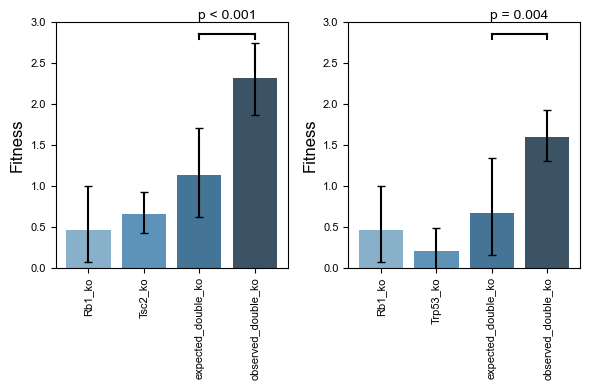

In [40]:
# Plot parameters
x_axis_p = 'genotype'
rotation_angle = 90
y_absolute = 0.95
h_absolute = 0.05  # Adjusted height for p-value annotation
x1 = 2
x2 = x1 + 1



# Panel setup
fig6, axes = plt.subplots(1, 2, figsize=(6, 4))
ax1,ax2 = axes.ravel()

# Trait for barplot
trait_of_interest = 'fitness'
bt_trait = f"{trait_of_interest}_bootstrap_median"


# panel 1
input_df = temp_df1
temp_ylim = (0, 3)
# Barplot with seaborn
sns.barplot(
    data=input_df,
    x=x_axis_p,
    y=bt_trait,
    ax=ax1,
    palette='Blues_d'
)

# Add error bars
yerr_lower = input_df[bt_trait] - input_df[f"{trait_of_interest}_2.5P"]
yerr_upper = input_df[f"{trait_of_interest}_97.5P"] - input_df[bt_trait]

ax1.errorbar(
    x=input_df[x_axis_p],
    y=input_df[bt_trait],
    yerr=[yerr_lower, yerr_upper],
    fmt='none', color='black', lw=1.5, capsize=3
)

# Add p-value annotation with horizontal line and ticks
ax1.plot([x1, x2], [y_absolute, y_absolute], lw=1.5, color='black',transform=ax1.get_xaxis_transform())
tick_height = 0.02  # Height of vertical ticks
ax1.plot([x1, x1], [y_absolute - tick_height, y_absolute], lw=1.5, color='black',transform=ax1.get_xaxis_transform())
ax1.plot([x2, x2], [y_absolute - tick_height, y_absolute], lw=1.5, color='black',transform=ax1.get_xaxis_transform())
ax1.text(
    (x1 + x2) * 0.5,
    y_absolute + h_absolute,
    p_text1,
    ha='center',
    va='bottom',
    color='black',
    transform=ax1.get_xaxis_transform()
)

# Customize plot
ax1.set_ylabel('Fitness', fontsize=12)
ax1.set_xlabel('')
ax1.set_ylim(temp_ylim)
ax1.tick_params(axis='x', labelrotation=rotation_angle, labelsize=10)
customize_plot(ax1, xaxis_title_size=12, 
               xaxis_tick_label_size=8, 
                   yaxis_title_size=12, 
                   yaxis_tick_label_size=8, 
                   panel_title='', 
                   panel_title_size=12,
                   xaxis_title=None)


# panel 1
input_df = temp_df2
temp_ylim = (0, 3)
# Barplot with seaborn
sns.barplot(
    data=input_df,
    x=x_axis_p,
    y=bt_trait,
    ax=ax2,
    palette='Blues_d'
)

# Add error bars
yerr_lower = input_df[bt_trait] - input_df[f"{trait_of_interest}_2.5P"]
yerr_upper = input_df[f"{trait_of_interest}_97.5P"] - input_df[bt_trait]

ax2.errorbar(
    x=input_df[x_axis_p],
    y=input_df[bt_trait],
    yerr=[yerr_lower, yerr_upper],
    fmt='none', color='black', lw=1.5, capsize=3
)

# Add p-value annotation with horizontal line and ticks
ax2.plot([x1, x2], [y_absolute, y_absolute], lw=1.5, color='black',transform=ax2.get_xaxis_transform())
tick_height = 0.02  # Height of vertical ticks
ax2.plot([x1, x1], [y_absolute - tick_height, y_absolute], lw=1.5, color='black',transform=ax2.get_xaxis_transform())
ax2.plot([x2, x2], [y_absolute - tick_height, y_absolute], lw=1.5, color='black',transform=ax2.get_xaxis_transform())
ax2.text(
    (x1 + x2) * 0.5,
    y_absolute + h_absolute,
    p_text2,
    ha='center',
    va='bottom',
    color='black',
    transform=ax2.get_xaxis_transform()
)

# Customize plot
ax2.set_ylabel('Fitness', fontsize=12)
ax2.set_xlabel('')
ax2.set_ylim(temp_ylim)
ax2.tick_params(axis='x', labelrotation=rotation_angle, labelsize=10)
customize_plot(ax2, xaxis_title_size=12, 
               xaxis_tick_label_size=8, 
                   yaxis_title_size=12, 
                   yaxis_tick_label_size=8, 
                   panel_title='', 
                   panel_title_size=12,
                   xaxis_title=None)


# Display the plot
plt.tight_layout()
plt.show()

## 9 Top2 negative epistasis examples

<font size="10" color="red"> Fig. 7(i) and S9(e)</font>

In [42]:
Cas12a_df = aggregated_two_way_results[aggregated_two_way_results.Mouse_genotype=='KTCas12a'].copy()

In [43]:
# Generate DataFrame
focal_genes = ['Arid1a', 'Tet2', 'Safe']

temp_g = '_'.join(sorted(focal_genes))
query_df = Cas12a_df[
    Cas12a_df.gene_combination_unordered == temp_g
].copy()

In [44]:
# Extract p-value and gene information
p_value = query_df['epistasis_pvalue_twoside'].values[0]
gene_a = f"{query_df.gene_a.values[0]}_ko"
gene_b = f"{query_df.gene_b.values[0]}_ko"
name_list = [gene_a, gene_b, 'expected_double_ko', 'observed_double_ko']

# Prepare trait lists
trait_list = ['ko_a_in_wt', 'ko_b_in_wt', 'expected_double_ko', 'observed_double_ko']
trait_list1 = [x + '_bootstrap_median' for x in trait_list]
trait_list2 = [x + '_2.5P' for x in trait_list]
trait_list3 = [x + '_97.5P' for x in trait_list]

# Construct DataFrame for plotting
temp_df = pd.DataFrame({
    'genotype': name_list,
    'fitness': query_df[trait_list].values[0],
    'fitness_bootstrap_median': query_df[trait_list1].values[0],
    'fitness_2.5P': query_df[trait_list2].values[0],
    'fitness_97.5P': query_df[trait_list3].values[0],
})

In [45]:
temp_df1 = temp_df

In [46]:
# Format p-value display
p_text1 = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.3f}"

In [47]:
# Generate DataFrame
focal_genes = ['Arid1a', 'Mga', 'Safe']

temp_g = '_'.join(sorted(focal_genes))
query_df = Cas12a_df[
    Cas12a_df.gene_combination_unordered == temp_g
].copy()

In [48]:
# Extract p-value and gene information
p_value = query_df['epistasis_pvalue_twoside'].values[0]
gene_a = f"{query_df.gene_a.values[0]}_ko"
gene_b = f"{query_df.gene_b.values[0]}_ko"
name_list = [gene_a, gene_b, 'expected_double_ko', 'observed_double_ko']

# Prepare trait lists
trait_list = ['ko_a_in_wt', 'ko_b_in_wt', 'expected_double_ko', 'observed_double_ko']
trait_list1 = [x + '_bootstrap_median' for x in trait_list]
trait_list2 = [x + '_2.5P' for x in trait_list]
trait_list3 = [x + '_97.5P' for x in trait_list]

# Construct DataFrame for plotting
temp_df = pd.DataFrame({
    'genotype': name_list,
    'fitness': query_df[trait_list].values[0],
    'fitness_bootstrap_median': query_df[trait_list1].values[0],
    'fitness_2.5P': query_df[trait_list2].values[0],
    'fitness_97.5P': query_df[trait_list3].values[0],
})

In [49]:
temp_df2 = temp_df

In [50]:
# Format p-value display
p_text2 = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.3f}"

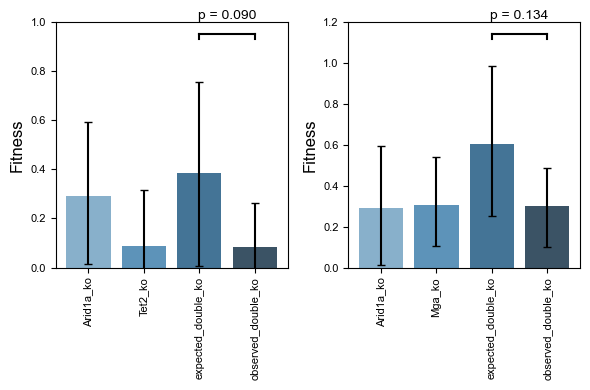

In [51]:
# Plot parameters
x_axis_p = 'genotype'
rotation_angle = 90
y_absolute = 0.95
h_absolute = 0.05  # Adjusted height for p-value annotation
x1 = 2
x2 = x1 + 1



# Panel setup
fig7, axes = plt.subplots(1, 2, figsize=(6, 4))
ax1,ax2 = axes.ravel()

# Trait for barplot
trait_of_interest = 'fitness'
bt_trait = f"{trait_of_interest}_bootstrap_median"


# panel 1
input_df = temp_df1
temp_ylim = (0, 1)
# Barplot with seaborn
sns.barplot(
    data=input_df,
    x=x_axis_p,
    y=bt_trait,
    ax=ax1,
    palette='Blues_d'
)

# Add error bars
yerr_lower = input_df[bt_trait] - input_df[f"{trait_of_interest}_2.5P"]
yerr_upper = input_df[f"{trait_of_interest}_97.5P"] - input_df[bt_trait]

ax1.errorbar(
    x=input_df[x_axis_p],
    y=input_df[bt_trait],
    yerr=[yerr_lower, yerr_upper],
    fmt='none', color='black', lw=1.5, capsize=3
)

# Add p-value annotation with horizontal line and ticks
ax1.plot([x1, x2], [y_absolute, y_absolute], lw=1.5, color='black',transform=ax1.get_xaxis_transform())
tick_height = 0.02  # Height of vertical ticks
ax1.plot([x1, x1], [y_absolute - tick_height, y_absolute], lw=1.5, color='black',transform=ax1.get_xaxis_transform())
ax1.plot([x2, x2], [y_absolute - tick_height, y_absolute], lw=1.5, color='black',transform=ax1.get_xaxis_transform())
ax1.text(
    (x1 + x2) * 0.5,
    y_absolute + h_absolute,
    p_text1,
    ha='center',
    va='bottom',
    color='black',
    transform=ax1.get_xaxis_transform()
)

# Customize plot
ax1.set_ylabel('Fitness', fontsize=12)
ax1.set_xlabel('')
ax1.set_ylim(temp_ylim)
ax1.tick_params(axis='x', labelrotation=rotation_angle, labelsize=10)
customize_plot(ax1, xaxis_title_size=12, 
               xaxis_tick_label_size=8, 
                   yaxis_title_size=12, 
                   yaxis_tick_label_size=8, 
                   panel_title='', 
                   panel_title_size=12,
                   xaxis_title=None)


# panel 1
input_df = temp_df2
temp_ylim = (0, 1.2)
# Barplot with seaborn
sns.barplot(
    data=input_df,
    x=x_axis_p,
    y=bt_trait,
    ax=ax2,
    palette='Blues_d'
)

# Add error bars
yerr_lower = input_df[bt_trait] - input_df[f"{trait_of_interest}_2.5P"]
yerr_upper = input_df[f"{trait_of_interest}_97.5P"] - input_df[bt_trait]

ax2.errorbar(
    x=input_df[x_axis_p],
    y=input_df[bt_trait],
    yerr=[yerr_lower, yerr_upper],
    fmt='none', color='black', lw=1.5, capsize=3
)

# Add p-value annotation with horizontal line and ticks
ax2.plot([x1, x2], [y_absolute, y_absolute], lw=1.5, color='black',transform=ax2.get_xaxis_transform())
tick_height = 0.02  # Height of vertical ticks
ax2.plot([x1, x1], [y_absolute - tick_height, y_absolute], lw=1.5, color='black',transform=ax2.get_xaxis_transform())
ax2.plot([x2, x2], [y_absolute - tick_height, y_absolute], lw=1.5, color='black',transform=ax2.get_xaxis_transform())
ax2.text(
    (x1 + x2) * 0.5,
    y_absolute + h_absolute,
    p_text2,
    ha='center',
    va='bottom',
    color='black',
    transform=ax2.get_xaxis_transform()
)

# Customize plot
ax2.set_ylabel('Fitness', fontsize=12)
ax2.set_xlabel('')
ax2.set_ylim(temp_ylim)
ax2.tick_params(axis='x', labelrotation=rotation_angle, labelsize=10)
customize_plot(ax2, xaxis_title_size=12, 
               xaxis_tick_label_size=8, 
                   yaxis_title_size=12, 
                   yaxis_tick_label_size=8, 
                   panel_title='', 
                   panel_title_size=12,
                   xaxis_title=None)


# Display the plot
plt.tight_layout()
plt.show()

---

## 10 Oberved vs Expected for 3-KO

### 10.1 KTCas12a

<font size="10" color="red"> Fig. 8(b) and (c)</font>

In [54]:
query_df = aggregated_three_way_results[aggregated_three_way_results.Mouse_genotype=='KTCas12a'].copy()

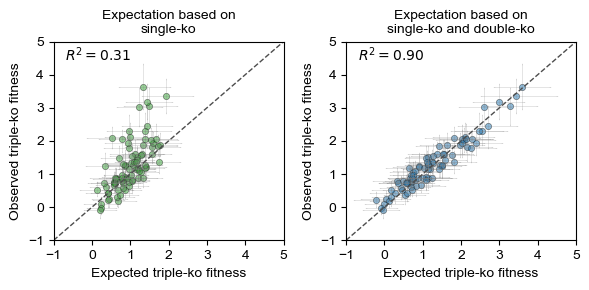

In [56]:
from sklearn.metrics import r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Panel setup
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
ax1, ax2 = axes.ravel()

# Common settings
dot_size = 20
error_alpha = 0.3  # Transparency for error bars
point_alpha = 0.5  # Transparency for points

# Global axis ranges
global_x_min, global_x_max = -1, 5
global_y_min, global_y_max = -1, 5

# Diagonal reference line range
temp1, temp2 = global_x_min, global_x_max

# Panel 1: Scatterplot and R^2 annotation
trait1 = 'expected_triple_ko_linear'
trait2 = 'observed_triple_ko'

# Scatterplot with transparency
sns.scatterplot(
    data=query_df,
    x=f'{trait1}_bootstrap_median',
    y=f'{trait2}_bootstrap_median',
    ax=ax1,
    s=dot_size,
    color='tab:green',
    edgecolor='black',
    linewidth=0.5,
    alpha=point_alpha
)

# Error bars
ax1.errorbar(
    x=query_df[f'{trait1}_bootstrap_median'],
    y=query_df[f'{trait2}_bootstrap_median'],
    xerr=[
        query_df[f'{trait1}_bootstrap_median'] - query_df[f'{trait1}_2.5P'],
        query_df[f'{trait1}_97.5P'] - query_df[f'{trait1}_bootstrap_median']
    ],
    yerr=[
        query_df[f'{trait2}_bootstrap_median'] - query_df[f'{trait2}_2.5P'],
        query_df[f'{trait2}_97.5P'] - query_df[f'{trait2}_bootstrap_median']
    ],
    linestyle='',
    color='gray',
    alpha=error_alpha,
    elinewidth=0.5,
    capsize=0.3
)

# Diagonal reference line
ax1.plot((temp1, temp2), (temp1, temp2), ls="--", color=".3", linewidth=1)

# Labels and title
ax1.set_xlabel("Expected triple-ko fitness", fontsize=10)
ax1.set_ylabel("Observed triple-ko fitness", fontsize=10)
ax1.set_title("Expectation based on\nsingle-ko", fontsize=10)

# Calculate and annotate R^2
x1 = query_df[f'{trait1}_bootstrap_median']
y1 = query_df[f'{trait2}_bootstrap_median']
r2_panel1 = r2_score(y1, x1)  # y=x regression
ax1.text(0.05, 0.9, f"$R^2 = {r2_panel1:.2f}$", fontsize=10, color="black",transform=ax1.transAxes)

# Panel 2: Scatterplot and R^2 annotation
trait1 = 'expected_triple_ko'

# Scatterplot with transparency
sns.scatterplot(
    data=query_df,
    x=f'{trait1}_bootstrap_median',
    y=f'{trait2}_bootstrap_median',
    ax=ax2,
    s=dot_size,
    color='tab:blue',
    edgecolor='black',
    linewidth=0.5,
    alpha=point_alpha
)

# Error bars
ax2.errorbar(
    x=query_df[f'{trait1}_bootstrap_median'],
    y=query_df[f'{trait2}_bootstrap_median'],
    xerr=[
        query_df[f'{trait1}_bootstrap_median'] - query_df[f'{trait1}_2.5P'],
        query_df[f'{trait1}_97.5P'] - query_df[f'{trait1}_bootstrap_median']
    ],
    yerr=[
        query_df[f'{trait2}_bootstrap_median'] - query_df[f'{trait2}_2.5P'],
        query_df[f'{trait2}_97.5P'] - query_df[f'{trait2}_bootstrap_median']
    ],
    linestyle='',
    color='gray',
    alpha=error_alpha,
    elinewidth=0.5,
    capsize=0.3
)

# Diagonal reference line
ax2.plot((temp1, temp2), (temp1, temp2), ls="--", color=".3", linewidth=1)

# Labels and title
ax2.set_xlabel("Expected triple-ko fitness", fontsize=10)
ax2.set_ylabel("Observed triple-ko fitness", fontsize=10)
ax2.set_title("Expectation based on\nsingle-ko and double-ko", fontsize=10)

# Calculate and annotate R^2
x2 = query_df[f'{trait1}_bootstrap_median']
y2 = query_df[f'{trait2}_bootstrap_median']
r2_panel2 = r2_score(y2, x2)  # y=x regression
ax2.text(0.05, 0.9, f"$R^2 = {r2_panel2:.2f}$", fontsize=10, color="black",transform=ax2.transAxes)

# Set consistent axis ranges for both panels
for ax in [ax1, ax2]:
    ax.set_xlim(global_x_min, global_x_max)
    ax.set_ylim(global_y_min, global_y_max)

# Set consistent tick marks
num_ticks = int((global_x_max-global_x_min)/1+1)
for ax in [ax1, ax2]:
    ax.set_xticks(np.linspace(global_x_min, global_x_max, num_ticks))
    ax.set_yticks(np.linspace(global_y_min, global_y_max, num_ticks))

# Final adjustments and display
plt.tight_layout()
plt.show()
# Output fig


### 10.2 KT

<font size="10" color="red"> Fig. S10(b) and (c)</font>

In [60]:
query_df = aggregated_three_way_results[aggregated_three_way_results.Mouse_genotype=='KT'].copy()

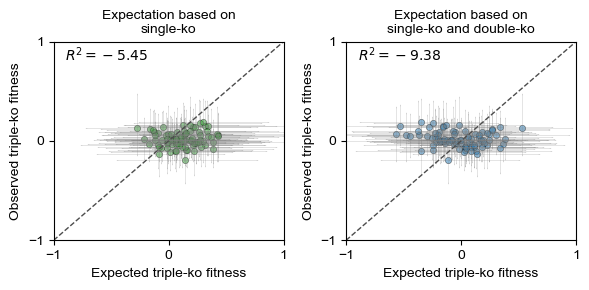

In [61]:
from sklearn.metrics import r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Panel setup
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
ax1, ax2 = axes.ravel()

# Common settings
dot_size = 20
error_alpha = 0.3  # Transparency for error bars
point_alpha = 0.5  # Transparency for points

# Global axis ranges
global_x_min, global_x_max = -1, 1
global_y_min, global_y_max = -1, 1

# Diagonal reference line range
temp1, temp2 = global_x_min, global_x_max

# Panel 1: Scatterplot and R^2 annotation
trait1 = 'expected_triple_ko_linear'
trait2 = 'observed_triple_ko'

# Scatterplot with transparency
sns.scatterplot(
    data=query_df,
    x=f'{trait1}_bootstrap_median',
    y=f'{trait2}_bootstrap_median',
    ax=ax1,
    s=dot_size,
    color='tab:green',
    edgecolor='black',
    linewidth=0.5,
    alpha=point_alpha
)

# Error bars
ax1.errorbar(
    x=query_df[f'{trait1}_bootstrap_median'],
    y=query_df[f'{trait2}_bootstrap_median'],
    xerr=[
        query_df[f'{trait1}_bootstrap_median'] - query_df[f'{trait1}_2.5P'],
        query_df[f'{trait1}_97.5P'] - query_df[f'{trait1}_bootstrap_median']
    ],
    yerr=[
        query_df[f'{trait2}_bootstrap_median'] - query_df[f'{trait2}_2.5P'],
        query_df[f'{trait2}_97.5P'] - query_df[f'{trait2}_bootstrap_median']
    ],
    linestyle='',
    color='gray',
    alpha=error_alpha,
    elinewidth=0.5,
    capsize=0.3
)

# Diagonal reference line
ax1.plot((temp1, temp2), (temp1, temp2), ls="--", color=".3", linewidth=1)

# Labels and title
ax1.set_xlabel("Expected triple-ko fitness", fontsize=10)
ax1.set_ylabel("Observed triple-ko fitness", fontsize=10)
ax1.set_title("Expectation based on\nsingle-ko", fontsize=10)

# Calculate and annotate R^2
x1 = query_df[f'{trait1}_bootstrap_median']
y1 = query_df[f'{trait2}_bootstrap_median']
r2_panel1 = r2_score(y1, x1)  # y=x regression
ax1.text(0.05, 0.9, f"$R^2 = {r2_panel1:.2f}$", fontsize=10, color="black",transform=ax1.transAxes)

# Panel 2: Scatterplot and R^2 annotation
trait1 = 'expected_triple_ko'

# Scatterplot with transparency
sns.scatterplot(
    data=query_df,
    x=f'{trait1}_bootstrap_median',
    y=f'{trait2}_bootstrap_median',
    ax=ax2,
    s=dot_size,
    color='tab:blue',
    edgecolor='black',
    linewidth=0.5,
    alpha=point_alpha
)

# Error bars
ax2.errorbar(
    x=query_df[f'{trait1}_bootstrap_median'],
    y=query_df[f'{trait2}_bootstrap_median'],
    xerr=[
        query_df[f'{trait1}_bootstrap_median'] - query_df[f'{trait1}_2.5P'],
        query_df[f'{trait1}_97.5P'] - query_df[f'{trait1}_bootstrap_median']
    ],
    yerr=[
        query_df[f'{trait2}_bootstrap_median'] - query_df[f'{trait2}_2.5P'],
        query_df[f'{trait2}_97.5P'] - query_df[f'{trait2}_bootstrap_median']
    ],
    linestyle='',
    color='gray',
    alpha=error_alpha,
    elinewidth=0.5,
    capsize=0.3
)

# Diagonal reference line
ax2.plot((temp1, temp2), (temp1, temp2), ls="--", color=".3", linewidth=1)

# Labels and title
ax2.set_xlabel("Expected triple-ko fitness", fontsize=10)
ax2.set_ylabel("Observed triple-ko fitness", fontsize=10)
ax2.set_title("Expectation based on\nsingle-ko and double-ko", fontsize=10)

# Calculate and annotate R^2
x2 = query_df[f'{trait1}_bootstrap_median']
y2 = query_df[f'{trait2}_bootstrap_median']
r2_panel2 = r2_score(y2, x2)  # y=x regression
ax2.text(0.05, 0.9, f"$R^2 = {r2_panel2:.2f}$", fontsize=10, color="black",transform=ax2.transAxes)

# Set consistent axis ranges for both panels
for ax in [ax1, ax2]:
    ax.set_xlim(global_x_min, global_x_max)
    ax.set_ylim(global_y_min, global_y_max)

# Set consistent tick marks
num_ticks = int((global_x_max-global_x_min)/1+1)
for ax in [ax1, ax2]:
    ax.set_xticks(np.linspace(global_x_min, global_x_max, num_ticks))
    ax.set_yticks(np.linspace(global_y_min, global_y_max, num_ticks))

# Final adjustments and display
plt.tight_layout()
plt.show()
# Output fig


## 11 Epistasis heat map (fig9)

<font size="10" color="red"> Fig. 8(a)</font>

In [62]:
query_df = aggregated_three_way_results[aggregated_three_way_results.Mouse_genotype=='KTCas12a'].copy()

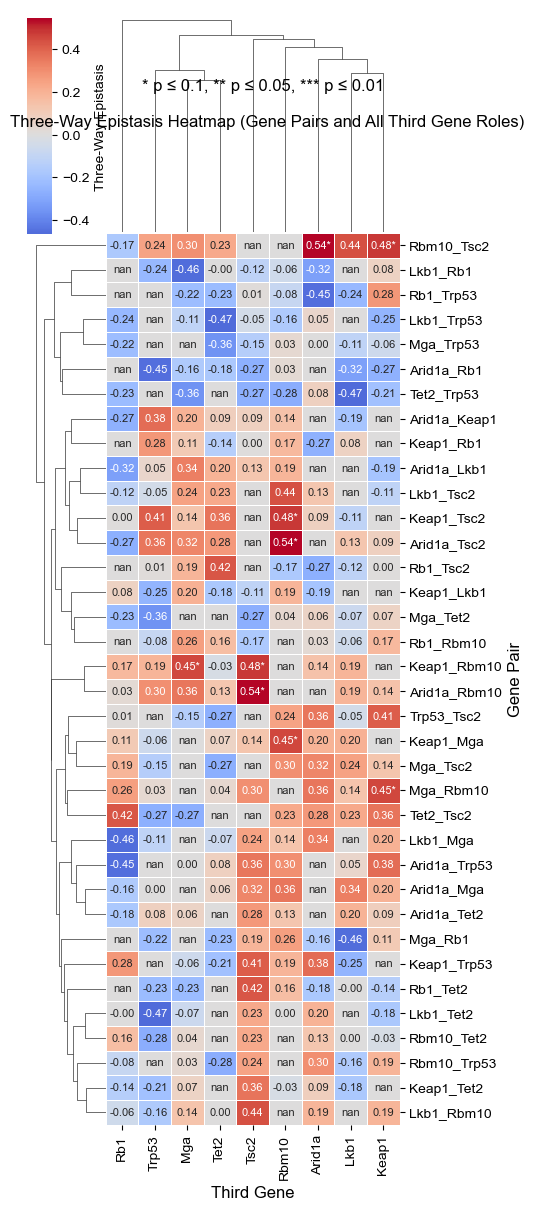

In [63]:
# Combine KO effects and p-values for sorting genes
gene_effects = pd.concat([
    query_df[['gene_a', 'ko_a_in_wt_bootstrap_median']].rename(columns={
        'gene_a': 'gene',
        'ko_a_in_wt_bootstrap_median': 'ko_effect'
    }),
    query_df[['gene_b', 'ko_b_in_wt_bootstrap_median']].rename(columns={
        'gene_b': 'gene',
        'ko_b_in_wt_bootstrap_median': 'ko_effect'
    }),
    query_df[['gene_c', 'ko_c_in_wt_bootstrap_median']].rename(columns={
        'gene_c': 'gene',
        'ko_c_in_wt_bootstrap_median': 'ko_effect'
    })
])
gene_effects = gene_effects.drop_duplicates()

# Calculate mean KO effect for each gene and sort
sorted_genes = (
    gene_effects.groupby('gene')['ko_effect']
    .mean()
    .sort_values(ascending=False)
    .index.tolist()
)

# Prepare the data
gene_pairs = query_df.apply(
    lambda x: [f"{x['gene_a']}_{x['gene_b']}", f"{x['gene_b']}_{x['gene_c']}", f"{x['gene_a']}_{x['gene_c']}"], axis=1
).explode().unique()

# Rows: All gene pairs; Columns: All genes that can be the third
three_way_matrix = pd.DataFrame(index=gene_pairs, columns=sorted_genes, data=np.nan)
annotations = three_way_matrix.copy()

# Fill the matrix
for _, row in query_df.iterrows():
    gene_a, gene_b, gene_c = row['gene_a'], row['gene_b'], row['gene_c']
    epistasis_value = row['epistasis_bootstrap_median']
    p_value = row['epistasis_pvalue_twoside']
    
    # Consider all roles for gene_a, gene_b, and gene_c
    gene_pairs_roles = {
        f"{gene_a}_{gene_b}": gene_c,
        f"{gene_b}_{gene_c}": gene_a,
        f"{gene_a}_{gene_c}": gene_b   # Symmetric for c_a and a_c
    }
    
    for gene_pair, third_gene in gene_pairs_roles.items():
        # Ensure that only valid third genes are considered (exclude genes in the pair)
        valid_columns = [col for col in sorted_genes if col not in gene_pair.split('_')]
        if third_gene in valid_columns:
            # Populate the matrix for both `gene_pair` and its reciprocal
            three_way_matrix.loc[gene_pair, third_gene] = epistasis_value
            # Add annotation for significance
            if p_value < 0.01:
                annotations.loc[gene_pair, third_gene] = f"{epistasis_value:.2f}***"
            elif p_value < 0.05:
                annotations.loc[gene_pair, third_gene] = f"{epistasis_value:.2f}**"
            elif p_value < 0.1:
                annotations.loc[gene_pair, third_gene] = f"{epistasis_value:.2f}*"
            else:
                annotations.loc[gene_pair, third_gene] = f"{epistasis_value:.2f}"
# Replace NaN values with 0
three_way_matrix_filled = three_way_matrix.fillna(0)

# Create the clustermap
clustergrid = sns.clustermap(
    three_way_matrix_filled,  # Use the cleaned matrix
    annot=annotations,  # Add annotations
    fmt="",  # Annotation format
    cmap="coolwarm",  # Color map for heatmap
    cbar_kws={'label': 'Three-Way Epistasis'},  # Add color bar label
    annot_kws={'size': 8},  # Annotation font size
    center=0,  # Center the colormap at 0
    linewidths=0.5,  # Add gridlines
    row_cluster=True,  # Enable clustering for rows
    col_cluster=True,  # Disable clustering for columns
    figsize=(5, 12)  # Figure size
)
# clustergrid.ax_cbar.set_position([1.0, 0.6, 0.03, 0.2])  # [left, bottom, width, height]

# Customize heatmap axis labels
clustergrid.ax_heatmap.set_xlabel("Third Gene", fontsize=12)
clustergrid.ax_heatmap.set_ylabel("Gene Pair", fontsize=12)

# Customize tick label sizes
clustergrid.ax_heatmap.tick_params(axis='x', labelsize=10, rotation=90)
clustergrid.ax_heatmap.tick_params(axis='y', labelsize=10)

# Extract the matplotlib Figure object
fig9 = clustergrid.fig

# Add a title to the figure
fig9.suptitle(
    "Three-Way Epistasis Heatmap (Gene Pairs and All Third Gene Roles)",
    fontsize=12,
    x=0.5,
    y=0.90
)

# Add criteria for stars
fig9.text(
    0.25, 0.92,
    "* p ≤ 0.1, ** p ≤ 0.05, *** p ≤ 0.01",
    fontsize=12, ha='left', color='black'
)
plt.show()

## 12 Trajectory for ASM

In [64]:
gene_df_Cas12a = gene_df[gene_df.Mouse_genotype=='KTCas12a']

### 12.1 'Trp53', 'Rb1', 'Lkb1'

<font size="10" color="red"> Fig. 8(d)</font>

In [65]:
query_df = gene_df_Cas12a[gene_df_Cas12a.Array_category.isin(['Triple_TSG','Double_TSG','Single_TSG','Triple_Inert'])].copy()
trait_of_interest = 'Fitness'
# Define the focal genes
focal_genes = ['Trp53', 'Rb1', 'Lkb1']
bt_trait = f'{trait_of_interest}_bootstrap_median'
low_trait = f'{trait_of_interest}_2.5P'
up_trait = f'{trait_of_interest}_97.5P'

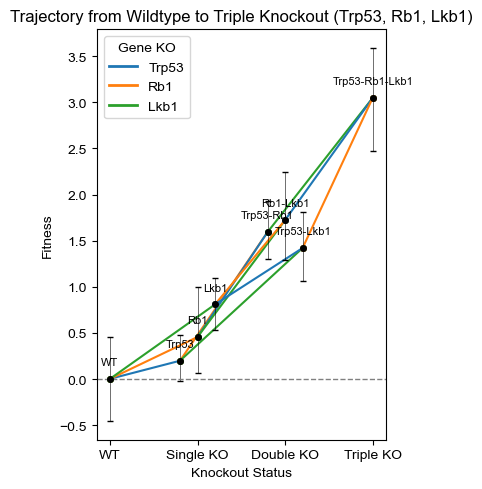

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example: Replace with your actual data
# query_df contains the states and corresponding trait values
# trait_of_interest is the column name for the trait being analyzed

marker_size = 4

# Define the trait columns
bt_trait = f'{trait_of_interest}_bootstrap_median'
low_trait = f'{trait_of_interest}_2.5P'
up_trait = f'{trait_of_interest}_97.5P'

# Define function to calculate the trait and CIs for a specific state
def get_trait_values(state):
    try:
        values = query_df.loc[
            query_df['gene_combination_unordered'] == state,
            [bt_trait, low_trait, up_trait]
        ].values[0]
        return values
    except IndexError:
        return [np.nan, np.nan, np.nan]  # Return NaN if the state is missing

# Define all states for the given focal_genes
gene_a, gene_b, gene_c = focal_genes
wildtype = '_'.join(sorted(['Safe', 'Safe', 'Safe']))
single_ko_a = '_'.join(sorted([gene_a, 'Safe', 'Safe']))
single_ko_b = '_'.join(sorted([gene_b, 'Safe', 'Safe']))
single_ko_c = '_'.join(sorted([gene_c, 'Safe', 'Safe']))
double_ko_ab = '_'.join(sorted([gene_a, gene_b, 'Safe']))
double_ko_bc = '_'.join(sorted([gene_b, gene_c, 'Safe']))
double_ko_ac = '_'.join(sorted([gene_a, gene_c, 'Safe']))
triple_ko = '_'.join(sorted([gene_a, gene_b, gene_c]))

# Retrieve trait values and confidence intervals for each state
states = [wildtype, single_ko_a, single_ko_b, single_ko_c, double_ko_ab, double_ko_bc, double_ko_ac, triple_ko]
state_labels = ['WT', f'{gene_a}', f'{gene_b}', f'{gene_c}',
                f'{gene_a}-{gene_b}', f'{gene_b}-{gene_c}', f'{gene_a}-{gene_c}',
                f'{gene_a}-{gene_b}-{gene_c}']
trait_data = [get_trait_values(state) for state in states]
trait_means, trait_lows, trait_highs = zip(*trait_data)

# Skip if any state is missing
if np.any(pd.isna(trait_means)):
    print(f"Missing data for {focal_genes}. Cannot plot.")
else:
    # Normalize to WT (set WT to 1)
    normalized_means = [val for val in trait_means]
    log2_means = normalized_means
    log2_lows = [low for low in trait_lows]
    log2_highs =[high for high in trait_highs]
    
    # Define x-axis levels and apply slight shifts
    x_positions = [0, 1 - 0.2, 1, 1 + 0.2, 2 - 0.2, 2, 2 + 0.2, 3]
    grouped_labels = ['WT', 'Single KO', 'Double KO', 'Triple KO']  # Grouped labels
    grouped_positions = [0, 1, 2, 3]  # Tick positions for grouped labels

    # Define colors for each gene
    color_palette = plt.cm.tab10.colors  # Use matplotlib colormap for distinct colors
    gene_colors = {gene: color_palette[i % len(color_palette)] for i, gene in enumerate(focal_genes)}

    # Create plot
    fig, ax = plt.subplots(figsize=(4, 5))

    # WT → Single KOs
    ax.plot([x_positions[0], x_positions[1]], [log2_means[0], log2_means[1]], 'o-', color=gene_colors[gene_a], markersize=marker_size)
    ax.plot([x_positions[0], x_positions[2]], [log2_means[0], log2_means[2]], 'o-', color=gene_colors[gene_b], markersize=marker_size)
    ax.plot([x_positions[0], x_positions[3]], [log2_means[0], log2_means[3]], 'o-', color=gene_colors[gene_c], markersize=marker_size)

    # Single KO → Double KOs
    ax.plot([x_positions[1], x_positions[4]], [log2_means[1], log2_means[4]], 'o-', color=gene_colors[gene_b], markersize=marker_size)
    ax.plot([x_positions[1], x_positions[6]], [log2_means[1], log2_means[6]], 'o-', color=gene_colors[gene_c], markersize=marker_size)
    ax.plot([x_positions[2], x_positions[4]], [log2_means[2], log2_means[4]], 'o-', color=gene_colors[gene_a], markersize=marker_size)
    ax.plot([x_positions[2], x_positions[5]], [log2_means[2], log2_means[5]], 'o-', color=gene_colors[gene_c], markersize=marker_size)
    ax.plot([x_positions[3], x_positions[5]], [log2_means[3], log2_means[5]], 'o-', color=gene_colors[gene_b], markersize=marker_size)
    ax.plot([x_positions[3], x_positions[6]], [log2_means[3], log2_means[6]], 'o-', color=gene_colors[gene_a], markersize=marker_size)

    # Double KO → Triple KO
    ax.plot([x_positions[4], x_positions[7]], [log2_means[4], log2_means[7]], 'o-', color=gene_colors[gene_c], markersize=marker_size)
    ax.plot([x_positions[5], x_positions[7]], [log2_means[5], log2_means[7]], 'o-', color=gene_colors[gene_a], markersize=marker_size)
    ax.plot([x_positions[6], x_positions[7]], [log2_means[6], log2_means[7]], 'o-', color=gene_colors[gene_b], markersize=marker_size)

    # Add error bars (CI)
    for x, mean, low, high in zip(x_positions, log2_means, log2_lows, log2_highs):
        ax.errorbar(x, mean, yerr=[[mean - low], [high - mean]], fmt='o', color='black', capsize=2, elinewidth=0.4, markersize=marker_size)

    # Annotate points with genotypes
    for i, txt in enumerate(state_labels):
        ax.annotate(txt, (x_positions[i], log2_means[i]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

    # Legend
    handles = [plt.Line2D([0], [0], color=color, lw=2, label=gene) for gene, color in gene_colors.items()]
    ax.legend(handles=handles, title='Gene KO', loc='upper left')

    # Customize plot
    ax.set_xticks(grouped_positions)
    ax.set_xticklabels(grouped_labels, rotation=0, ha='center')
    ax.set_xlabel('Knockout Status')
    ax.set_ylabel(f'Fitness')
    ax.set_title(f"Trajectory from Wildtype to Triple Knockout ({gene_a}, {gene_b}, {gene_c})")
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    plt.tight_layout()

    # Show the figure (optional)
    plt.show()
customize_plot(ax, xaxis_title_size=12, 
               xaxis_tick_label_size=8, 
                   yaxis_title_size=12, 
                   yaxis_tick_label_size=8, 
                   panel_title=None, 
                   panel_title_size=12,
                   xaxis_title=None)

### 12.2 'Trp53', 'Arid1a', 'Tet2'

<font size="10" color="red"> Fig. 8(e)</font>

In [68]:
query_df = gene_df[gene_df.Array_category.isin(['Triple_TSG','Double_TSG','Single_TSG','Triple_Inert'])].copy()
trait_of_interest = 'Fitness'
# Define the focal genes
focal_genes = ['Trp53', 'Arid1a', 'Tet2']
bt_trait = f'{trait_of_interest}_bootstrap_median'
low_trait = f'{trait_of_interest}_2.5P'
up_trait = f'{trait_of_interest}_97.5P'

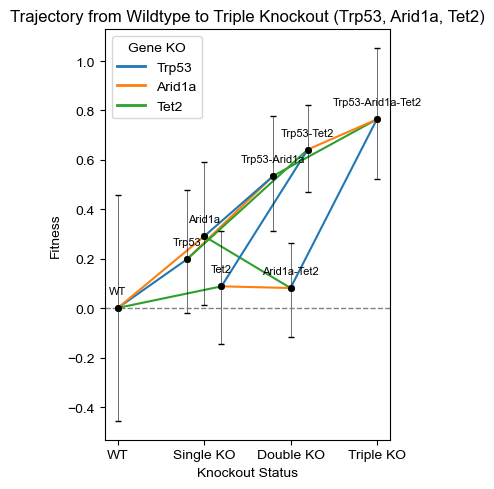

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example: Replace with your actual data
# query_df contains the states and corresponding trait values
# trait_of_interest is the column name for the trait being analyzed

marker_size = 4

# Define the trait columns
bt_trait = f'{trait_of_interest}_bootstrap_median'
low_trait = f'{trait_of_interest}_2.5P'
up_trait = f'{trait_of_interest}_97.5P'

# Define function to calculate the trait and CIs for a specific state
def get_trait_values(state):
    try:
        values = query_df.loc[
            query_df['gene_combination_unordered'] == state,
            [bt_trait, low_trait, up_trait]
        ].values[0]
        return values
    except IndexError:
        return [np.nan, np.nan, np.nan]  # Return NaN if the state is missing

# Define all states for the given focal_genes
gene_a, gene_b, gene_c = focal_genes
wildtype = '_'.join(sorted(['Safe', 'Safe', 'Safe']))
single_ko_a = '_'.join(sorted([gene_a, 'Safe', 'Safe']))
single_ko_b = '_'.join(sorted([gene_b, 'Safe', 'Safe']))
single_ko_c = '_'.join(sorted([gene_c, 'Safe', 'Safe']))
double_ko_ab = '_'.join(sorted([gene_a, gene_b, 'Safe']))
double_ko_bc = '_'.join(sorted([gene_b, gene_c, 'Safe']))
double_ko_ac = '_'.join(sorted([gene_a, gene_c, 'Safe']))
triple_ko = '_'.join(sorted([gene_a, gene_b, gene_c]))

# Retrieve trait values and confidence intervals for each state
states = [wildtype, single_ko_a, single_ko_b, single_ko_c, double_ko_ab, double_ko_bc, double_ko_ac, triple_ko]
state_labels = ['WT', f'{gene_a}', f'{gene_b}', f'{gene_c}',
                f'{gene_a}-{gene_b}', f'{gene_b}-{gene_c}', f'{gene_a}-{gene_c}',
                f'{gene_a}-{gene_b}-{gene_c}']
trait_data = [get_trait_values(state) for state in states]
trait_means, trait_lows, trait_highs = zip(*trait_data)

# Skip if any state is missing
if np.any(pd.isna(trait_means)):
    print(f"Missing data for {focal_genes}. Cannot plot.")
else:
    # Normalize to WT (set WT to 1)
    normalized_means = [val for val in trait_means]
    log2_means = normalized_means
    log2_lows = [low for low in trait_lows]
    log2_highs =[high for high in trait_highs]
    
    # Define x-axis levels and apply slight shifts
    x_positions = [0, 1 - 0.2, 1, 1 + 0.2, 2 - 0.2, 2, 2 + 0.2, 3]
    grouped_labels = ['WT', 'Single KO', 'Double KO', 'Triple KO']  # Grouped labels
    grouped_positions = [0, 1, 2, 3]  # Tick positions for grouped labels

    # Define colors for each gene
    color_palette = plt.cm.tab10.colors  # Use matplotlib colormap for distinct colors
    gene_colors = {gene: color_palette[i % len(color_palette)] for i, gene in enumerate(focal_genes)}

    # Create plot
    fig, ax = plt.subplots(figsize=(4, 5))

    # WT → Single KOs
    ax.plot([x_positions[0], x_positions[1]], [log2_means[0], log2_means[1]], 'o-', color=gene_colors[gene_a], markersize=marker_size)
    ax.plot([x_positions[0], x_positions[2]], [log2_means[0], log2_means[2]], 'o-', color=gene_colors[gene_b], markersize=marker_size)
    ax.plot([x_positions[0], x_positions[3]], [log2_means[0], log2_means[3]], 'o-', color=gene_colors[gene_c], markersize=marker_size)

    # Single KO → Double KOs
    ax.plot([x_positions[1], x_positions[4]], [log2_means[1], log2_means[4]], 'o-', color=gene_colors[gene_b], markersize=marker_size)
    ax.plot([x_positions[1], x_positions[6]], [log2_means[1], log2_means[6]], 'o-', color=gene_colors[gene_c], markersize=marker_size)
    ax.plot([x_positions[2], x_positions[4]], [log2_means[2], log2_means[4]], 'o-', color=gene_colors[gene_a], markersize=marker_size)
    ax.plot([x_positions[2], x_positions[5]], [log2_means[2], log2_means[5]], 'o-', color=gene_colors[gene_c], markersize=marker_size)
    ax.plot([x_positions[3], x_positions[5]], [log2_means[3], log2_means[5]], 'o-', color=gene_colors[gene_b], markersize=marker_size)
    ax.plot([x_positions[3], x_positions[6]], [log2_means[3], log2_means[6]], 'o-', color=gene_colors[gene_a], markersize=marker_size)

    # Double KO → Triple KO
    ax.plot([x_positions[4], x_positions[7]], [log2_means[4], log2_means[7]], 'o-', color=gene_colors[gene_c], markersize=marker_size)
    ax.plot([x_positions[5], x_positions[7]], [log2_means[5], log2_means[7]], 'o-', color=gene_colors[gene_a], markersize=marker_size)
    ax.plot([x_positions[6], x_positions[7]], [log2_means[6], log2_means[7]], 'o-', color=gene_colors[gene_b], markersize=marker_size)

    # Add error bars (CI)
    for x, mean, low, high in zip(x_positions, log2_means, log2_lows, log2_highs):
        ax.errorbar(x, mean, yerr=[[mean - low], [high - mean]], fmt='o', color='black', capsize=2, elinewidth=0.4, markersize=marker_size)

    # Annotate points with genotypes
    for i, txt in enumerate(state_labels):
        ax.annotate(txt, (x_positions[i], log2_means[i]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

    # Legend
    handles = [plt.Line2D([0], [0], color=color, lw=2, label=gene) for gene, color in gene_colors.items()]
    ax.legend(handles=handles, title='Gene KO', loc='upper left')

    # Customize plot
    ax.set_xticks(grouped_positions)
    ax.set_xticklabels(grouped_labels, rotation=0, ha='center')
    ax.set_xlabel('Knockout Status')
    ax.set_ylabel(f'Fitness')
    ax.set_title(f"Trajectory from Wildtype to Triple Knockout ({gene_a}, {gene_b}, {gene_c})")
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    plt.tight_layout()

    # Show the figure (optional)
    plt.show()
customize_plot(ax, xaxis_title_size=12, 
               xaxis_tick_label_size=8, 
                   yaxis_title_size=12, 
                   yaxis_tick_label_size=8, 
                   panel_title=None, 
                   panel_title_size=12,
                   xaxis_title=None)

### 12.3 'Trp53', 'Keap1', 'Mga'

<font size="10" color="red"> Fig. S10(d)</font>

In [70]:
query_df = gene_df[gene_df.Array_category.isin(['Triple_TSG','Double_TSG','Single_TSG','Triple_Inert'])].copy()
trait_of_interest = 'Fitness'
# Define the focal genes
focal_genes = ['Trp53', 'Keap1', 'Mga']
bt_trait = f'{trait_of_interest}_bootstrap_median'
low_trait = f'{trait_of_interest}_2.5P'
up_trait = f'{trait_of_interest}_97.5P'

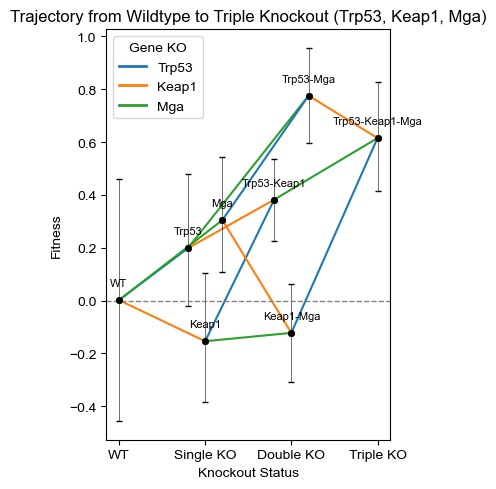

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example: Replace with your actual data
# query_df contains the states and corresponding trait values
# trait_of_interest is the column name for the trait being analyzed

marker_size = 4

# Define the trait columns
bt_trait = f'{trait_of_interest}_bootstrap_median'
low_trait = f'{trait_of_interest}_2.5P'
up_trait = f'{trait_of_interest}_97.5P'

# Define function to calculate the trait and CIs for a specific state
def get_trait_values(state):
    try:
        values = query_df.loc[
            query_df['gene_combination_unordered'] == state,
            [bt_trait, low_trait, up_trait]
        ].values[0]
        return values
    except IndexError:
        return [np.nan, np.nan, np.nan]  # Return NaN if the state is missing

# Define all states for the given focal_genes
gene_a, gene_b, gene_c = focal_genes
wildtype = '_'.join(sorted(['Safe', 'Safe', 'Safe']))
single_ko_a = '_'.join(sorted([gene_a, 'Safe', 'Safe']))
single_ko_b = '_'.join(sorted([gene_b, 'Safe', 'Safe']))
single_ko_c = '_'.join(sorted([gene_c, 'Safe', 'Safe']))
double_ko_ab = '_'.join(sorted([gene_a, gene_b, 'Safe']))
double_ko_bc = '_'.join(sorted([gene_b, gene_c, 'Safe']))
double_ko_ac = '_'.join(sorted([gene_a, gene_c, 'Safe']))
triple_ko = '_'.join(sorted([gene_a, gene_b, gene_c]))

# Retrieve trait values and confidence intervals for each state
states = [wildtype, single_ko_a, single_ko_b, single_ko_c, double_ko_ab, double_ko_bc, double_ko_ac, triple_ko]
state_labels = ['WT', f'{gene_a}', f'{gene_b}', f'{gene_c}',
                f'{gene_a}-{gene_b}', f'{gene_b}-{gene_c}', f'{gene_a}-{gene_c}',
                f'{gene_a}-{gene_b}-{gene_c}']
trait_data = [get_trait_values(state) for state in states]
trait_means, trait_lows, trait_highs = zip(*trait_data)

# Skip if any state is missing
if np.any(pd.isna(trait_means)):
    print(f"Missing data for {focal_genes}. Cannot plot.")
else:
    # Normalize to WT (set WT to 1)
    normalized_means = [val for val in trait_means]
    log2_means = normalized_means
    log2_lows = [low for low in trait_lows]
    log2_highs =[high for high in trait_highs]
    
    # Define x-axis levels and apply slight shifts
    x_positions = [0, 1 - 0.2, 1, 1 + 0.2, 2 - 0.2, 2, 2 + 0.2, 3]
    grouped_labels = ['WT', 'Single KO', 'Double KO', 'Triple KO']  # Grouped labels
    grouped_positions = [0, 1, 2, 3]  # Tick positions for grouped labels

    # Define colors for each gene
    color_palette = plt.cm.tab10.colors  # Use matplotlib colormap for distinct colors
    gene_colors = {gene: color_palette[i % len(color_palette)] for i, gene in enumerate(focal_genes)}

    # Create plot
    fig, ax = plt.subplots(figsize=(4, 5))

    # WT → Single KOs
    ax.plot([x_positions[0], x_positions[1]], [log2_means[0], log2_means[1]], 'o-', color=gene_colors[gene_a], markersize=marker_size)
    ax.plot([x_positions[0], x_positions[2]], [log2_means[0], log2_means[2]], 'o-', color=gene_colors[gene_b], markersize=marker_size)
    ax.plot([x_positions[0], x_positions[3]], [log2_means[0], log2_means[3]], 'o-', color=gene_colors[gene_c], markersize=marker_size)

    # Single KO → Double KOs
    ax.plot([x_positions[1], x_positions[4]], [log2_means[1], log2_means[4]], 'o-', color=gene_colors[gene_b], markersize=marker_size)
    ax.plot([x_positions[1], x_positions[6]], [log2_means[1], log2_means[6]], 'o-', color=gene_colors[gene_c], markersize=marker_size)
    ax.plot([x_positions[2], x_positions[4]], [log2_means[2], log2_means[4]], 'o-', color=gene_colors[gene_a], markersize=marker_size)
    ax.plot([x_positions[2], x_positions[5]], [log2_means[2], log2_means[5]], 'o-', color=gene_colors[gene_c], markersize=marker_size)
    ax.plot([x_positions[3], x_positions[5]], [log2_means[3], log2_means[5]], 'o-', color=gene_colors[gene_b], markersize=marker_size)
    ax.plot([x_positions[3], x_positions[6]], [log2_means[3], log2_means[6]], 'o-', color=gene_colors[gene_a], markersize=marker_size)

    # Double KO → Triple KO
    ax.plot([x_positions[4], x_positions[7]], [log2_means[4], log2_means[7]], 'o-', color=gene_colors[gene_c], markersize=marker_size)
    ax.plot([x_positions[5], x_positions[7]], [log2_means[5], log2_means[7]], 'o-', color=gene_colors[gene_a], markersize=marker_size)
    ax.plot([x_positions[6], x_positions[7]], [log2_means[6], log2_means[7]], 'o-', color=gene_colors[gene_b], markersize=marker_size)

    # Add error bars (CI)
    for x, mean, low, high in zip(x_positions, log2_means, log2_lows, log2_highs):
        ax.errorbar(x, mean, yerr=[[mean - low], [high - mean]], fmt='o', color='black', capsize=2, elinewidth=0.4, markersize=marker_size)

    # Annotate points with genotypes
    for i, txt in enumerate(state_labels):
        ax.annotate(txt, (x_positions[i], log2_means[i]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

    # Legend
    handles = [plt.Line2D([0], [0], color=color, lw=2, label=gene) for gene, color in gene_colors.items()]
    ax.legend(handles=handles, title='Gene KO', loc='upper left')

    # Customize plot
    ax.set_xticks(grouped_positions)
    ax.set_xticklabels(grouped_labels, rotation=0, ha='center')
    ax.set_xlabel('Knockout Status')
    ax.set_ylabel(f'Fitness')
    ax.set_title(f"Trajectory from Wildtype to Triple Knockout ({gene_a}, {gene_b}, {gene_c})")
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    plt.tight_layout()

    # Show the figure (optional)
    plt.show()
customize_plot(ax, xaxis_title_size=12, 
               xaxis_tick_label_size=8, 
                   yaxis_title_size=12, 
                   yaxis_tick_label_size=8, 
                   panel_title=None, 
                   panel_title_size=12,
                   xaxis_title=None)
fig10 = fig

### 12.4 'Ari1a', 'Rb1', 'Mga'

<font size="10" color="red"> Fig. S10(e)</font>

In [72]:
query_df = gene_df[gene_df.Array_category.isin(['Triple_TSG','Double_TSG','Single_TSG','Triple_Inert'])].copy()
trait_of_interest = 'Fitness'
# Define the focal genes
focal_genes = ['Arid1a', 'Rb1', 'Mga']
bt_trait = f'{trait_of_interest}_bootstrap_median'
low_trait = f'{trait_of_interest}_2.5P'
up_trait = f'{trait_of_interest}_97.5P'

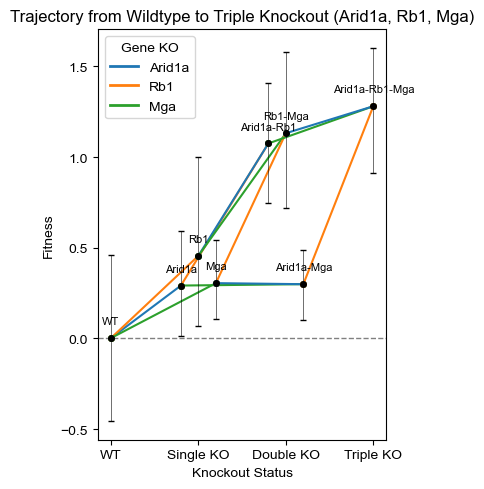

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example: Replace with your actual data
# query_df contains the states and corresponding trait values
# trait_of_interest is the column name for the trait being analyzed

marker_size = 4

# Define the trait columns
bt_trait = f'{trait_of_interest}_bootstrap_median'
low_trait = f'{trait_of_interest}_2.5P'
up_trait = f'{trait_of_interest}_97.5P'

# Define function to calculate the trait and CIs for a specific state
def get_trait_values(state):
    try:
        values = query_df.loc[
            query_df['gene_combination_unordered'] == state,
            [bt_trait, low_trait, up_trait]
        ].values[0]
        return values
    except IndexError:
        return [np.nan, np.nan, np.nan]  # Return NaN if the state is missing

# Define all states for the given focal_genes
gene_a, gene_b, gene_c = focal_genes
wildtype = '_'.join(sorted(['Safe', 'Safe', 'Safe']))
single_ko_a = '_'.join(sorted([gene_a, 'Safe', 'Safe']))
single_ko_b = '_'.join(sorted([gene_b, 'Safe', 'Safe']))
single_ko_c = '_'.join(sorted([gene_c, 'Safe', 'Safe']))
double_ko_ab = '_'.join(sorted([gene_a, gene_b, 'Safe']))
double_ko_bc = '_'.join(sorted([gene_b, gene_c, 'Safe']))
double_ko_ac = '_'.join(sorted([gene_a, gene_c, 'Safe']))
triple_ko = '_'.join(sorted([gene_a, gene_b, gene_c]))

# Retrieve trait values and confidence intervals for each state
states = [wildtype, single_ko_a, single_ko_b, single_ko_c, double_ko_ab, double_ko_bc, double_ko_ac, triple_ko]
state_labels = ['WT', f'{gene_a}', f'{gene_b}', f'{gene_c}',
                f'{gene_a}-{gene_b}', f'{gene_b}-{gene_c}', f'{gene_a}-{gene_c}',
                f'{gene_a}-{gene_b}-{gene_c}']
trait_data = [get_trait_values(state) for state in states]
trait_means, trait_lows, trait_highs = zip(*trait_data)

# Skip if any state is missing
if np.any(pd.isna(trait_means)):
    print(f"Missing data for {focal_genes}. Cannot plot.")
else:
    # Normalize to WT (set WT to 1)
    normalized_means = [val for val in trait_means]
    log2_means = normalized_means
    log2_lows = [low for low in trait_lows]
    log2_highs =[high for high in trait_highs]
    
    # Define x-axis levels and apply slight shifts
    x_positions = [0, 1 - 0.2, 1, 1 + 0.2, 2 - 0.2, 2, 2 + 0.2, 3]
    grouped_labels = ['WT', 'Single KO', 'Double KO', 'Triple KO']  # Grouped labels
    grouped_positions = [0, 1, 2, 3]  # Tick positions for grouped labels

    # Define colors for each gene
    color_palette = plt.cm.tab10.colors  # Use matplotlib colormap for distinct colors
    gene_colors = {gene: color_palette[i % len(color_palette)] for i, gene in enumerate(focal_genes)}

    # Create plot
    fig, ax = plt.subplots(figsize=(4, 5))

    # WT → Single KOs
    ax.plot([x_positions[0], x_positions[1]], [log2_means[0], log2_means[1]], 'o-', color=gene_colors[gene_a], markersize=marker_size)
    ax.plot([x_positions[0], x_positions[2]], [log2_means[0], log2_means[2]], 'o-', color=gene_colors[gene_b], markersize=marker_size)
    ax.plot([x_positions[0], x_positions[3]], [log2_means[0], log2_means[3]], 'o-', color=gene_colors[gene_c], markersize=marker_size)

    # Single KO → Double KOs
    ax.plot([x_positions[1], x_positions[4]], [log2_means[1], log2_means[4]], 'o-', color=gene_colors[gene_b], markersize=marker_size)
    ax.plot([x_positions[1], x_positions[6]], [log2_means[1], log2_means[6]], 'o-', color=gene_colors[gene_c], markersize=marker_size)
    ax.plot([x_positions[2], x_positions[4]], [log2_means[2], log2_means[4]], 'o-', color=gene_colors[gene_a], markersize=marker_size)
    ax.plot([x_positions[2], x_positions[5]], [log2_means[2], log2_means[5]], 'o-', color=gene_colors[gene_c], markersize=marker_size)
    ax.plot([x_positions[3], x_positions[5]], [log2_means[3], log2_means[5]], 'o-', color=gene_colors[gene_b], markersize=marker_size)
    ax.plot([x_positions[3], x_positions[6]], [log2_means[3], log2_means[6]], 'o-', color=gene_colors[gene_a], markersize=marker_size)

    # Double KO → Triple KO
    ax.plot([x_positions[4], x_positions[7]], [log2_means[4], log2_means[7]], 'o-', color=gene_colors[gene_c], markersize=marker_size)
    ax.plot([x_positions[5], x_positions[7]], [log2_means[5], log2_means[7]], 'o-', color=gene_colors[gene_a], markersize=marker_size)
    ax.plot([x_positions[6], x_positions[7]], [log2_means[6], log2_means[7]], 'o-', color=gene_colors[gene_b], markersize=marker_size)

    # Add error bars (CI)
    for x, mean, low, high in zip(x_positions, log2_means, log2_lows, log2_highs):
        ax.errorbar(x, mean, yerr=[[mean - low], [high - mean]], fmt='o', color='black', capsize=2, elinewidth=0.4, markersize=marker_size)

    # Annotate points with genotypes
    for i, txt in enumerate(state_labels):
        ax.annotate(txt, (x_positions[i], log2_means[i]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

    # Legend
    handles = [plt.Line2D([0], [0], color=color, lw=2, label=gene) for gene, color in gene_colors.items()]
    ax.legend(handles=handles, title='Gene KO', loc='upper left')

    # Customize plot
    ax.set_xticks(grouped_positions)
    ax.set_xticklabels(grouped_labels, rotation=0, ha='center')
    ax.set_xlabel('Knockout Status')
    ax.set_ylabel(f'Fitness')
    ax.set_title(f"Trajectory from Wildtype to Triple Knockout ({gene_a}, {gene_b}, {gene_c})")
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    plt.tight_layout()

    # Show the figure (optional)
    plt.show()
customize_plot(ax, xaxis_title_size=12, 
               xaxis_tick_label_size=8, 
                   yaxis_title_size=12, 
                   yaxis_tick_label_size=8, 
                   panel_title=None, 
                   panel_title_size=12,
                   xaxis_title=None)
fig10 = fig